In [64]:
import gdspy
import qnldraw as qd
import qnldraw.junction as qj
import qnldraw.library as qlib
from qnldraw import Chip, shapes, components
import qnldraw.paths as paths
import numpy as np
import ruamel.yaml as yaml
from qnldraw.junction import JunctionArray
from qnldraw.junction import JunctionLead

In [132]:
class JunctionArray(components.Component):
    __draw__ = True
    
    def draw(self, n, overlap, wire, undercut):
        jx, jy = overlap
        wx, wy = wire
        undercut_wire, undercut_junction = undercut
        spacing = jy + wy
        
        positions = (np.arange(n) - (n-1)/2)*spacing
        
        for y in positions:
            junction_rect = shapes.Rectangle(jx, jy).translate(0, y)
            undercuts = [
                shapes.Rectangle(undercut_junction, jy, 'right', layer=1).translate(-jx/2, y),
                shapes.Rectangle(undercut_junction, jy, 'left', layer=1).translate(jx/2, y)
            ]
            
            self.add(junction_rect)
            self.add(undercuts)
            
        for i, y in enumerate(positions[:-1]):
            wire_rect = shapes.Rectangle(wx, wy, 'bottom').translate(0, y + 0.5*jy)
            undercuts = shapes.Rectangle(
                undercut_wire, wy, 'bottom left' if i%2 else 'bottom right', layer=1
            ).translate(
                (2*(i%2) - 1)*wx/2, y + 0.5*jy
            )

            self.add(wire_rect)
            self.add(undercuts)
            
        nodes = {
            'wire1': np.array((0, positions[-1] + 0.5*jy)),
            'wire2': np.array((0, positions[0] - 0.5*jy))
        }
        return nodes

class Junction_Small(components.Component):
    __draw__ = True

    def draw(self, lead, undercut):
        left_lead_x, left_lead_y, right_lead_x, right_lead_y = lead
        undercut_x, undercut_y = undercut

        offset_y = left_lead_y - right_lead_y
        leads = [
            shapes.Rectangle(right_lead_x, right_lead_y). translate((right_lead_x+undercut_x)/2,-right_lead_y-offset_y),
            shapes.Rectangle(left_lead_x, left_lead_y). translate(-(left_lead_x+undercut_x)/2,-left_lead_y)
        ]
        undercuts = shapes.Rectangle(undercut_x, left_lead_y+0.2, layer=1). translate(0,-left_lead_y)

        self.add(leads)
        self.add(undercuts)
        nodes = {
            'left': (-undercut_x/2, 0),
            'right': (undercut_x/2, 0)
        }
        return nodes
    
class Junction_Small_dolan(components.Component):
    __draw__ = True

    def draw(self, lead, finger, undercut):
        left_lead_x, left_lead_y, right_lead_x, right_lead_y = lead
        finger_x, finger_y = finger
        undercut_x, undercut_y = undercut
        
        leads = [
            shapes.Rectangle(right_lead_x, right_lead_y). translate((right_lead_x+undercut_x)/2,-(undercut_y/3-right_lead_y/2+0.1)),
            shapes.Rectangle(left_lead_x, left_lead_y). translate(-(left_lead_x+undercut_x)/2,(undercut_y/3-left_lead_y/2-0.1)),
            shapes.Rectangle(finger_x, finger_y).translate(undercut_x/2+finger_x/2,0)
        ]
        undercuts = shapes.Rectangle(undercut_x, undercut_y, layer=1)

        self.add(leads)
        self.add(undercuts)
        nodes = {
            'left': (-undercut_x/2, 0),
            'right': (undercut_x/2, 0)
        }
        return nodes
    
class JunctionLead(components.Component):
    __draw__ = True

    def draw(self, offset, lead, undercut):
        lead_x, lead_y = lead
        undercut_x, undercut_y = undercut
        offset_x, offset_y = offset
        leads = [
            shapes.Rectangle(lead_x, lead_y). translate(offset_x, -offset_y),
            shapes.Rectangle(lead_x, lead_y). translate(-offset_x, -offset_y)
        ]
        undercuts = [
            shapes.Rectangle(undercut_x, undercut_y, layer=1).translate(offset_x/2-lead_x/2+0.1, -offset_y),
            shapes.Rectangle(undercut_x, undercut_y, layer=1).translate(-(offset_x/2-lead_x/2+0.1), -offset_y)
        ]
        self.add(leads)
        self.add(undercuts)
        nodes = {
            'left': (-undercut_x/2, 0),
            'right': (undercut_x/2, 0)
        }
        return nodes
    
class AntennaSymmetric(components.Component):
    __draw__ = True
    
    def draw(self, pad, lead, gap, undercut):
        pad_x, pad_y = pad
        lead_x, lead_y = lead
        
        antenna = [
            shapes.Rectangle(pad_x, pad_y). translate((gap/2+lead_x+pad_x/2),0),
            shapes.Rectangle(pad_x, pad_y). translate(-(gap/2+lead_x+pad_x/2),0),
            shapes.Rectangle(lead_x, lead_y). translate(gap/2+lead_x/2,0),
            shapes.Rectangle(lead_x, lead_y). translate(-gap/2-lead_x/2,0)
        ]
        undercuts = [
            shapes.Rectangle(undercut, pad_y, layer=1).translate((gap/2+lead_x+pad_x+undercut/2),0),
            shapes.Rectangle(undercut, pad_y, layer=1).translate(-(gap/2+lead_x+pad_x+undercut/2),0),
            shapes.Rectangle(undercut, pad_y, layer=1).translate(-(gap/2+lead_x-undercut/2),0),
            shapes.Rectangle(undercut, pad_y, layer=1).translate((gap/2+lead_x-undercut/2),0),
            shapes.Rectangle(undercut, lead_y, layer=1).translate((gap-undercut)/2,0),
            shapes.Rectangle(undercut, lead_y, layer=1).translate(-(gap-undercut)/2,0)
            
        ]
        self.add(antenna)
        self.add(undercuts)
        nodes = {
            'left': (-gap/2,0),
            'right': (gap/2,0)
        }
        return nodes
    
class vertical_finger_small(components.Component):
    __draw__ = True

    def draw(self, jjsize, undercut):
      
        jj_x, jj_y = jjsize
        undercut_x, undercut_y = undercut
        
        leads = [
            shapes.Rectangle(jj_x, undercut_y).translate(undercut_x/2+jj_x/2,0)
        ]
        undercuts = shapes.Rectangle(undercut_x, undercut_y, layer=1)

        self.add(leads)
        self.add(undercuts)
        nodes = {
            'left': (-undercut_x/2, 0),
            'right': (undercut_x/2, 0)
        }
        return nodes

class mask_square(components.Component):
    __draw__ = True

    def draw(self, size):
      
        x_dim, y_dim = size
        
        square = [
            shapes.Rectangle(x_dim, y_dim)#.translate(-x_dim/2, -y_dim/2)
        ]
        self.add(square)
        nodes = {
            'center': (x_dim/2, y_dim/2),
            'left' : (-x_dim/2,0),
            'right': (x_dim/2,0)
        }
        return nodes

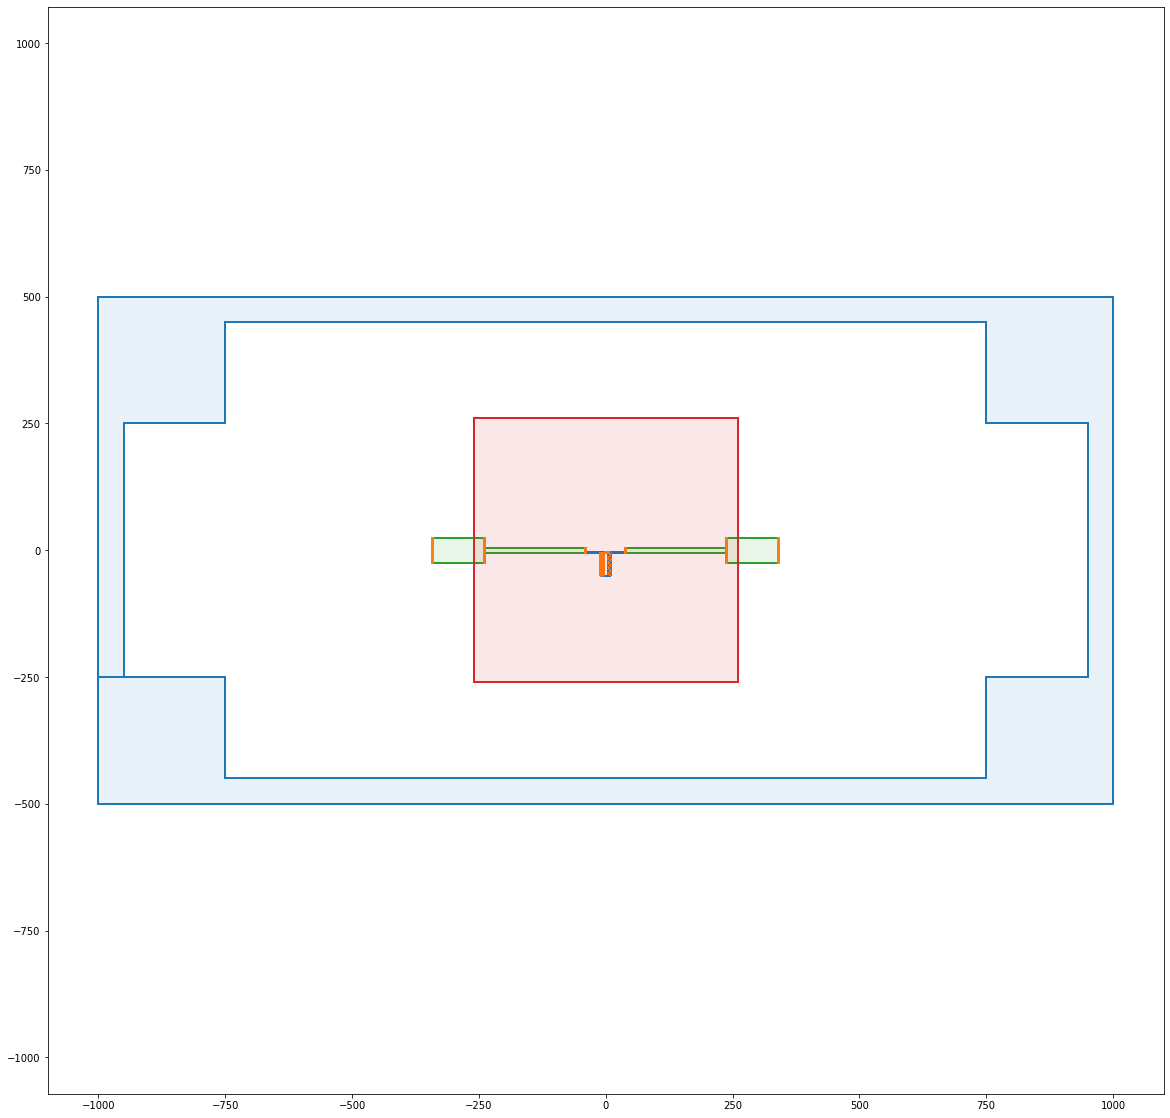

In [133]:
if __name__ == "__main__":
    lib = gdspy.GdsLibrary()
    chip = qd.Chip(size = (2000,1000))
    with open('parameters.yaml', 'r') as f:
        params = qd.Params(yaml.load(f, yaml.CSafeLoader))
        
    ####antenna
    pad = (100,50)
    antenna_lead = (200, 10)
    gap = 80
    undercut_antenna = 2
    antenna = AntennaSymmetric(pad, antenna_lead, gap, undercut_antenna)
    
    ####array
    n =  params['evaporation.junctions.number']
    overlap = params['evaporation.junctions.overlap'] # lx, ly, junction size
    wire = params['evaporation.junctions.wire']   # lx, ly, connecting piece between junctions
    undercut_wire = params['evaporation.junctions.undercut']     # undercut for wires
    undercut_junction = undercut_wire
    undercut = [undercut_wire, undercut_junction]
    undercut_after_JJ = params['evaporation.junctions.undercut_after_JJ'] # undercut after junction 
    array_gap = overlap[0] + 10
    offset_array = antenna_lead[1]-4 #move the array in -y direction
    array = JunctionArray(n=n, overlap=overlap, wire=wire, undercut=undercut)
    array1 = array.place((-array_gap/2, -offset_array), node='wire1', rotation=0)
    array2 = array.place((array_gap/2, -offset_array), node='wire1', rotation=0)
    
     
    ####small junction
    junction_lead = [6,0.12, 6,0.1] #left and right lead sizes in x and y
    junction_finger = [0.22, 0.8]
    junction_undercut = [1.1,1]
    offset_jj = [-0.5,-4.5]
    
    #Note: dose test sweeping: junction_lead[1], junction_finger[0], junction_undercut[0]
#     Type #1
#     jj = Junction_Small(junction_lead, junction_undercut)
#     junction_small = jj.place((offset_jj[0],offset_jj[1]), node ='left', rotation = 0)
    
    #Type #2
    jj = Junction_Small_dolan(junction_lead, junction_finger, junction_undercut)
    junction_small = jj.place((offset_jj[0],offset_jj[1]), node ='left', rotation = 0)
    
    
    #lead connecting arrays
    array_lead = shapes.Rectangle(array_gap, overlap[1], (array_gap/2, offset_array+n*(wire[1]+overlap[1])-wire[1]))  
    
    
    #lead connecting junction region to antenna
    j_lead_dim = [34, 1]
    j_lead_undercut = [1.2, 1]
    offset = [23,4.5]
    jjlead = JunctionLead(offset, j_lead_dim, j_lead_undercut)    

    #fingers connecting array to leads
    #Thanks to Zahra :)
    finger_size = [0.5,0.05]
    finger_undercut = [1.6,1.0]
    vertical_finger = vertical_finger_small(finger_size, finger_undercut)
    finger1=vertical_finger.place((-array_gap/2, -offset_array+wire[1]*2))
    finger2=vertical_finger.place((array_gap/2, -offset_array+wire[1]*2))
    
    #Defining dose layers
    dose_layers = [0,1]
    dose_layer_ant = [2]
    dose_layer_align = [3]
    evap_layers = params['evaporation.layers']
    
    #alignment square
    square_size = [520, 520]
    sqr = mask_square(square_size)
    
    #Adding components to chip
    chip.add_component(antenna, cid = 'antenna', layers=dose_layer_ant)
    chip.add_component(array1, cid = 'array1', layers=dose_layers)
    chip.add_component(array2, cid = 'array2', layers=dose_layers)
    chip.add_component(junction_small, cid = 'junction', layers=dose_layers)
    chip.add_component(array_lead, cid = 'array_lead', layers=dose_layers)
    chip.add_component(jjlead, cid = 'jjlead', layers=dose_layers)
    chip.add_component(finger1, cid = "finger1", layers=dose_layers)
    chip.add_component(finger2, cid = "finger2", layers=dose_layers)
    chip.add_component(sqr, cid = "square", layers=dose_layer_align)
    mask = chip.render(name = 'fluxonium', draw_border = True)
    
    fig = qd.plot(mask[0], figsize=(20,20), axis=True, grid=False)
    
    ## Simulate Evaporation
    cells = chip.render(name='fluxonium', draw_border=False)
    polys = cells[0].get_polygons(by_spec=True)
    highdose = gdspy.PolygonSet(polys[(dose_layers[0], 0)] + polys[(dose_layer_ant[0], 0)])
    lowdose = gdspy.PolygonSet(polys[(dose_layers[1], 0)])

    evaporated = qj.simulate_evaporation(
        lowdose, highdose, **params['evaporation']
    )
    for i, (layer, evap) in enumerate(zip(evap_layers, evaporated)):
        chip.add_component(evap, f'evap_{i}', layers=layer)
        
    cells = chip.render(name='fluxonium', draw_border=False)
    lib.write_gds('3D_fluxonium_2021Feb.gds', cells=cells)
    

In [108]:
# cells[0].plot(filter=lambda l, d: l in [4, 5, 6], figsize=(20, 20))

# cells[0].plot(filter=lambda l, d: l in [0, 1, 2], figsize=(20, 20))
